In [19]:
import pandas as pd 
import re
import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#train models 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sn
import matplotlib.pyplot as plt

# Get the data

In [20]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Studying the data

## Searching for null values

In [21]:
print("Equals to empty", len(train.loc[train['ABSTRACT'] == ""]))
print("Equals to none", len(train.loc[train['ABSTRACT'] == None]))

Equals to empty 0
Equals to none 0


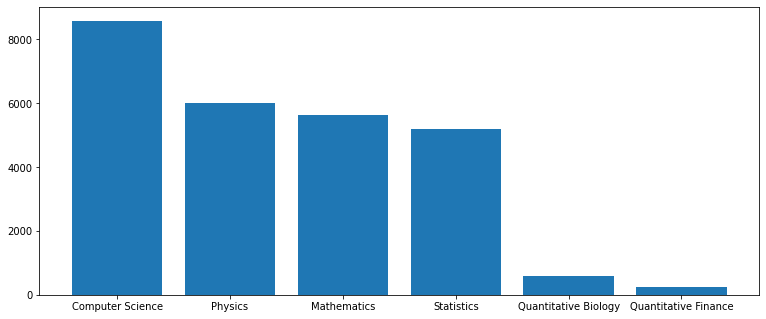

In [22]:
# What is the most common category 
cols = train.columns.tolist() 
cols = cols[3:]

train_sum = train[cols].sum() 
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(cols, train_sum)
plt.show()

## Correlation matrix


<AxesSubplot:>

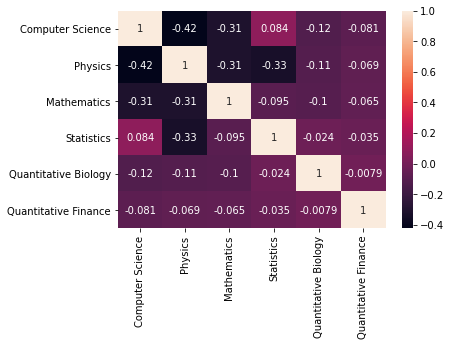

In [23]:
sn.heatmap(train[cols].corr(), annot=True)

## Size of abstract text + title

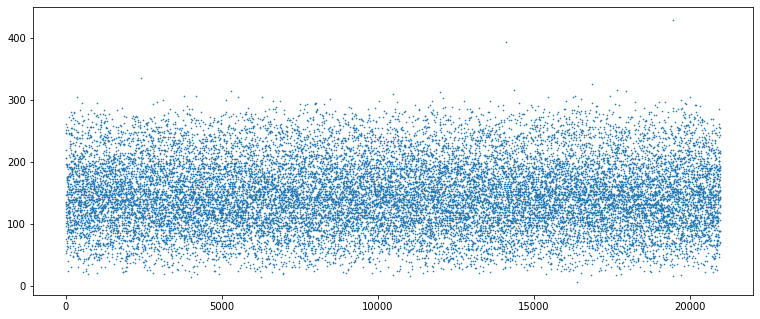

In [24]:
# if there's a text really large, we might cut it's size 
len_abstract = [len(i.split(' ')) for i in train['ABSTRACT']]
len_title = [len(i.split(' ')) for i in train['TITLE']]
len_text = [len_title[i] + len_abstract[i] for i in range(len(train))]
x = [i for i in range(len(train))]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
ax.scatter(x, len_text, s=0.4)
plt.show()

## Most frequent words 

/home/allanbs/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

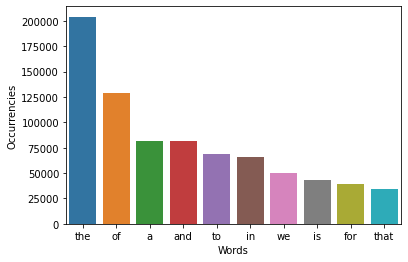

In [25]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['ABSTRACT']).lower().split()).value_counts()[:10]
mostUsedGraph = sn.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

# Cleaning data

## Preprocessing words

In [26]:
def normalize(df): 
    corpus = []
    ps = PorterStemmer()
    df_size = len(df) 
    for i in range(0,df_size):
        # get review and remove non alpha chars
        article = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
        # to lower-case and tokenize
        article = article.lower().split()
        # stemming and stop word removal
        article = ' '.join([ps.stem(w) for w in article if not w in set(stopwords.words('english'))])
        corpus.append(article)
    return corpus

# To avoid making this cleaning every time, we save teh output as a csv
def save_csv(corpus_train, file_name): 
    df = pd.DataFrame({'text': corpus_train})
    df.to_csv(file_name) 
    
train['ABSTRACT'] = train['TITLE'] +train['ABSTRACT']
corpus_train = normalize(train)
save_csv(corpus_train, 'preprocessed_train.csv')

test['ABSTRACT'] = test['TITLE'] + test['ABSTRACT']
corpus_test = normalize(test)
save_csv(corpus_test, 'preprocessed_test.csv')


# Split input and output

In [27]:
def get_input(preprocessed, x_col_name): 
    vectorizer = CountVectorizer(max_features = 1500)

    X_array = preprocessed.loc[:,x_col_name]
    X = vectorizer.fit_transform(X_array).toarray()
    return X

def get_outputs(df, y_cols_name):
    y = []
    for col_name in y_cols_name: 
        col_values = df.loc[:,col_name].values
        y.append(col_values)
    return y


preprocessed = pd.read_csv('preprocessed_train.csv')
preprocessed_submission = pd.read_csv('preprocessed_test.csv')
y_columns = train.columns[3:]
X = get_input(preprocessed, 'text')
y = get_outputs(train, y_columns)
X_submission = get_input(preprocessed_submission, 'text')

# Split train and test sets

In [28]:
y_train_test = []
for i in range(len(y_columns)): 
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.20, random_state = 0)
    y_train_test.append([y_train, y_test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16777, 1500) (16777,)
(4195, 1500) (4195,)


# Train the model and generate results

In [29]:
def print_statistics(y_test, y_pred, column_name): 
    print(confusion_matrix(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))

In [30]:


classifier = GaussianNB()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 

for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()

index_submission= test.loc[:, 'ID'].values
print(len(gaussian_submission_df))
gaussian_submission_df = gaussian_submission_df.set_index(pd.Index(index_submission), 'ID')
gaussian_df.index.name = "ID"    
print(gaussian_submission_df)
gaussian_df.to_csv("submission_gaussian.csv")

COL: Computer Science
[[1622  829]
 [ 139 1605]]
Accuracy:  0.769249106078665
Precision:  0.6594083812654067
Recall:  0.9202981651376146
F1:  0.7683101962661559

COL: Physics
[[2749  250]
 [ 177 1019]]
Accuracy:  0.8982121573301549
Precision:  0.8029944838455477
Recall:  0.8520066889632107
F1:  0.8267748478701827

COL: Mathematics
[[2397  723]
 [ 111  964]]
Accuracy:  0.8011918951132301
Precision:  0.5714285714285714
Recall:  0.8967441860465116
F1:  0.6980448950036205

COL: Statistics
[[1828 1341]
 [  86  940]]
Accuracy:  0.6598331346841478
Precision:  0.4120999561595791
Recall:  0.9161793372319688
F1:  0.5684910795282734

COL: Quantitative Biology
[[2632 1447]
 [  32   84]]
Accuracy:  0.6474374255065555
Precision:  0.054866100587851074
Recall:  0.7241379310344828
F1:  0.10200364298724954

COL: Quantitative Finance
[[3750  395]
 [  25   25]]
Accuracy:  0.899880810488677
Precision:  0.05952380952380952
Recall:  0.5
F1:  0.10638297872340424

8989
       Computer Science  Physics  Mathema

In [31]:
# SVM

from sklearn.svm import LinearSVC


classifier = LinearSVC()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    
    

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

COL: Computer Science


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[2121  330]
 [ 365 1379]]
Accuracy:  0.834326579261025
Precision:  0.8069046225863078
Recall:  0.7907110091743119
F1:  0.7987257457283523

COL: Physics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[2832  167]
 [ 214  982]]
Accuracy:  0.9091775923718712
Precision:  0.8546562228024369
Recall:  0.8210702341137124
F1:  0.8375266524520255

COL: Mathematics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[2855  265]
 [ 233  842]]
Accuracy:  0.8812872467222884
Precision:  0.7606142728093948
Recall:  0.7832558139534884
F1:  0.771769019248396

COL: Statistics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[2924  245]
 [ 344  682]]
Accuracy:  0.8595947556615018
Precision:  0.7357065803667745
Recall:  0.6647173489278753
F1:  0.6984126984126985

COL: Quantitative Biology


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[3945  134]
 [  77   39]]
Accuracy:  0.9497020262216925
Precision:  0.2254335260115607
Recall:  0.33620689655172414
F1:  0.2698961937716263

COL: Quantitative Finance
[[4121   24]
 [  31   19]]
Accuracy:  0.9868891537544696
Precision:  0.4418604651162791
Recall:  0.38
F1:  0.40860215053763443

[[4121   24]
 [  31   19]]
Accuracy:  0.9868891537544696
Precision:  0.4418604651162791
Recall:  0.38
F1:  0.40860215053763443


In [32]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

COL: Computer Science


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2140  311]
 [ 382 1362]]
Accuracy:  0.8348033373063171
Precision:  0.8141063956963539
Recall:  0.7809633027522935
F1:  0.797190517998244

COL: Physics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2833  166]
 [ 205  991]]
Accuracy:  0.9115613825983313
Precision:  0.8565254969749352
Recall:  0.8285953177257525
F1:  0.8423289417764556

COL: Mathematics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2852  268]
 [ 229  846]]
Accuracy:  0.8815256257449344
Precision:  0.7594254937163375
Recall:  0.7869767441860465
F1:  0.7729556875285517

COL: Statistics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[2908  261]
 [ 331  695]]
Accuracy:  0.8588796185935638
Precision:  0.7269874476987448
Recall:  0.6773879142300195
F1:  0.7013118062563068

COL: Quantitative Biology


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[4000   79]
 [  79   37]]
Accuracy:  0.9623361144219309
Precision:  0.31896551724137934
Recall:  0.31896551724137934
F1:  0.31896551724137934

COL: Quantitative Finance
[[4132   13]
 [  30   20]]
Accuracy:  0.9897497020262217
Precision:  0.6060606060606061
Recall:  0.4
F1:  0.4819277108433735

[[4132   13]
 [  30   20]]
Accuracy:  0.9897497020262217
Precision:  0.6060606060606061
Recall:  0.4
F1:  0.4819277108433735


In [33]:
# Perceptron

from sklearn.linear_model import Perceptron

classifier = Perceptron()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

COL: Computer Science
[[2005  446]
 [ 385 1359]]
Accuracy:  0.8019070321811681
Precision:  0.7529085872576178
Recall:  0.779243119266055
F1:  0.7658495350803043

COL: Physics
[[2830  169]
 [ 220  976]]
Accuracy:  0.9072705601907032
Precision:  0.8524017467248908
Recall:  0.8160535117056856
F1:  0.8338316958564717

COL: Mathematics
[[2885  235]
 [ 272  803]]
Accuracy:  0.8791418355184744
Precision:  0.7736030828516378
Recall:  0.7469767441860465
F1:  0.7600567912920019

COL: Statistics
[[2853  316]
 [ 410  616]]
Accuracy:  0.8269368295589988
Precision:  0.6609442060085837
Recall:  0.6003898635477583
F1:  0.6292134831460674

COL: Quantitative Biology
[[3951  128]
 [  77   39]]
Accuracy:  0.9511323003575686
Precision:  0.23353293413173654
Recall:  0.33620689655172414
F1:  0.2756183745583039

COL: Quantitative Finance
[[4113   32]
 [  29   21]]
Accuracy:  0.9854588796185936
Precision:  0.39622641509433965
Recall:  0.42
F1:  0.4077669902912621

[[4113   32]
 [  29   21]]
Accuracy:  0.985458

In [34]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

COL: Computer Science
[[1942  509]
 [ 508 1236]]
Accuracy:  0.7575685339690107
Precision:  0.7083094555873926
Recall:  0.7087155963302753
F1:  0.708512467755804

COL: Physics
[[2704  295]
 [ 282  914]]
Accuracy:  0.8624553039332539
Precision:  0.7559966914805625
Recall:  0.7642140468227425
F1:  0.7600831600831601

COL: Mathematics
[[2728  392]
 [ 343  732]]
Accuracy:  0.8247914183551848
Precision:  0.6512455516014235
Recall:  0.6809302325581396
F1:  0.6657571623465213

COL: Statistics
[[2749  420]
 [ 391  635]]
Accuracy:  0.8066746126340882
Precision:  0.6018957345971564
Recall:  0.6189083820662769
F1:  0.6102835175396444

COL: Quantitative Biology
[[4006   73]
 [  90   26]]
Accuracy:  0.9611442193087009
Precision:  0.26262626262626265
Recall:  0.22413793103448276
F1:  0.24186046511627907

COL: Quantitative Finance
[[4108   37]
 [  36   14]]
Accuracy:  0.9825983313468415
Precision:  0.27450980392156865
Recall:  0.28
F1:  0.27722772277227725

[[4108   37]
 [  36   14]]
Accuracy:  0.9825

In [35]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("COL:", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    
    classifier.fit(X_train, y_train)
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

COL: Computer Science
[[2054  397]
 [ 235 1509]]
Accuracy:  0.8493444576877235
Precision:  0.7917103882476391
Recall:  0.8652522935779816
F1:  0.8268493150684931

COL: Physics
[[2908   91]
 [ 260  936]]
Accuracy:  0.9163289630512514
Precision:  0.9113924050632911
Recall:  0.782608695652174
F1:  0.8421052631578948

COL: Mathematics
[[3038   82]
 [ 359  716]]
Accuracy:  0.8948748510131108
Precision:  0.8972431077694235
Recall:  0.666046511627907
F1:  0.7645488521089162

COL: Statistics
[[2983  186]
 [ 366  660]]
Accuracy:  0.868414779499404
Precision:  0.7801418439716312
Recall:  0.6432748538011696
F1:  0.705128205128205

COL: Quantitative Biology
[[4079    0]
 [ 116    0]]
Accuracy:  0.9723480333730632
Precision:  0.0
Recall:  0.0
F1:  0.0

COL: Quantitative Finance


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[4145    0]
 [  49    1]]
Accuracy:  0.9883194278903457
Precision:  1.0
Recall:  0.02
F1:  0.0392156862745098

[[4145    0]
 [  49    1]]
Accuracy:  0.9883194278903457
Precision:  1.0
Recall:  0.02
F1:  0.0392156862745098
